In [35]:
%pip install scikit-learn torch torchvision --quiet

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.datasets import fetch_rcv1
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt


Note: you may need to restart the kernel to use updated packages.


In [36]:
rcv1 = fetch_rcv1()
X = rcv1.data      # Sparse matrix (804414, 47236)
y = rcv1.target    # Multi-label (804414, 103)

print(f"Feature matrix shape: {X.shape}")
print(f"Target matrix shape: {y.shape}")

# Convert to single-label classification
y_single = y.argmax(axis=1).A1

# Encode to contiguous 0-indexed class labels
label_encoder = LabelEncoder()
y_single = label_encoder.fit_transform(y_single)

# Optional: sample subset for faster training
sample_size = 50000
X = X[:sample_size]
y_single = y_single[:sample_size]


Feature matrix shape: (804414, 47236)
Target matrix shape: (804414, 103)


In [37]:
X_train, X_val, y_train, y_val = train_test_split(X, y_single, test_size=0.2, random_state=42)

X_train_tensor = torch.FloatTensor(X_train.toarray())
X_val_tensor = torch.FloatTensor(X_val.toarray())
y_train_tensor = torch.LongTensor(y_train)
y_val_tensor = torch.LongTensor(y_val)


In [38]:
class NoDropoutNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(NoDropoutNet, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):
        return self.model(x)


In [39]:
class DropoutNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout_rate=0.5):
        super(DropoutNet, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout_rate),  # Apply dropout here
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):
        return self.model(x)


In [40]:
input_dim = X.shape[1]
hidden_dim = 512
output_dim = len(np.unique(y_single))

epochs = 10
batch_size = 256


In [41]:
import os

# Recreate the model architecture
model = NoDropoutNet(input_dim, hidden_dim, output_dim)
model_path = "nodropout_model.pth"

# Check if model is already saved
if os.path.exists(model_path):
    print("Loading saved NoDropout model from file...")
    model.load_state_dict(torch.load(model_path))
    model.eval()
    # Optionally skip plotting if you're not training
    train_acc_list = []
    val_acc_list = []
else:
    print("Training NoDropout model from scratch...")

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    train_acc_list = []
    val_acc_list = []

    for epoch in range(epochs):
        model.train()
        permutation = torch.randperm(X_train_tensor.size()[0])

        for i in range(0, X_train_tensor.size()[0], batch_size):
            indices = permutation[i:i + batch_size]
            batch_x = X_train_tensor[indices]
            batch_y = y_train_tensor[indices]

            optimizer.zero_grad()
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()

        model.eval()
        with torch.no_grad():
            train_preds = torch.argmax(model(X_train_tensor), dim=1)
            train_acc = accuracy_score(y_train_tensor, train_preds)

            val_preds = torch.argmax(model(X_val_tensor), dim=1)
            val_acc = accuracy_score(y_val_tensor, val_preds)

        train_acc_list.append(train_acc)
        val_acc_list.append(val_acc)

        print(f"Epoch {epoch+1}/{epochs} | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")

    # Save model to file
    torch.save(model.state_dict(), model_path)
    print(f"Model saved to {model_path}")


Training NoDropout model from scratch...
Epoch 1/10 | Train Acc: 0.8025 | Val Acc: 0.7671
Epoch 2/10 | Train Acc: 0.8968 | Val Acc: 0.8147
Epoch 3/10 | Train Acc: 0.9412 | Val Acc: 0.8191
Epoch 4/10 | Train Acc: 0.9654 | Val Acc: 0.8185
Epoch 5/10 | Train Acc: 0.9768 | Val Acc: 0.8166
Epoch 6/10 | Train Acc: 0.9822 | Val Acc: 0.8169
Epoch 7/10 | Train Acc: 0.9838 | Val Acc: 0.8108
Epoch 8/10 | Train Acc: 0.9860 | Val Acc: 0.8120
Epoch 9/10 | Train Acc: 0.9869 | Val Acc: 0.8119
Epoch 10/10 | Train Acc: 0.9874 | Val Acc: 0.8119
Model saved to nodropout_model.pth


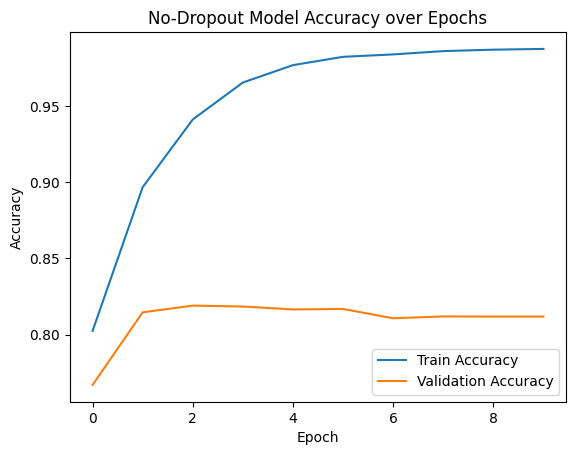

In [42]:
plt.plot(train_acc_list, label='Train Accuracy')
plt.plot(val_acc_list, label='Validation Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("No-Dropout Model Accuracy over Epochs")
plt.legend()
plt.show()


In [43]:
import os

# Recreate the model architecture
model = DropoutNet(input_dim, hidden_dim, output_dim)
model_path = "dropout_model.pth"

# Check if model is already saved
if os.path.exists(model_path):
    print("Loading saved model from file...")
    model.load_state_dict(torch.load(model_path))
    model.eval()
else:
    print("Training model from scratch...")

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    train_acc_list = []
    val_acc_list = []

    for epoch in range(epochs):
        model.train()
        permutation = torch.randperm(X_train_tensor.size()[0])

        for i in range(0, X_train_tensor.size()[0], batch_size):
            indices = permutation[i:i + batch_size]
            batch_x = X_train_tensor[indices]
            batch_y = y_train_tensor[indices]

            optimizer.zero_grad()
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()

        model.eval()
        with torch.no_grad():
            train_preds = torch.argmax(model(X_train_tensor), dim=1)
            train_acc = accuracy_score(y_train_tensor, train_preds)

            val_preds = torch.argmax(model(X_val_tensor), dim=1)
            val_acc = accuracy_score(y_val_tensor, val_preds)

        train_acc_list.append(train_acc)
        val_acc_list.append(val_acc)

        print(f"Epoch {epoch+1}/{epochs} | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")

    # Save model to file
    torch.save(model.state_dict(), model_path)
    print(f"Model saved to {model_path}")


Training model from scratch...
Epoch 1/10 | Train Acc: 0.7567 | Val Acc: 0.7346
Epoch 2/10 | Train Acc: 0.8562 | Val Acc: 0.8001
Epoch 3/10 | Train Acc: 0.9033 | Val Acc: 0.8182
Epoch 4/10 | Train Acc: 0.9321 | Val Acc: 0.8207
Epoch 5/10 | Train Acc: 0.9543 | Val Acc: 0.8227
Epoch 6/10 | Train Acc: 0.9675 | Val Acc: 0.8217
Epoch 7/10 | Train Acc: 0.9749 | Val Acc: 0.8195
Epoch 8/10 | Train Acc: 0.9792 | Val Acc: 0.8192
Epoch 9/10 | Train Acc: 0.9819 | Val Acc: 0.8190
Epoch 10/10 | Train Acc: 0.9843 | Val Acc: 0.8173
Model saved to dropout_model.pth


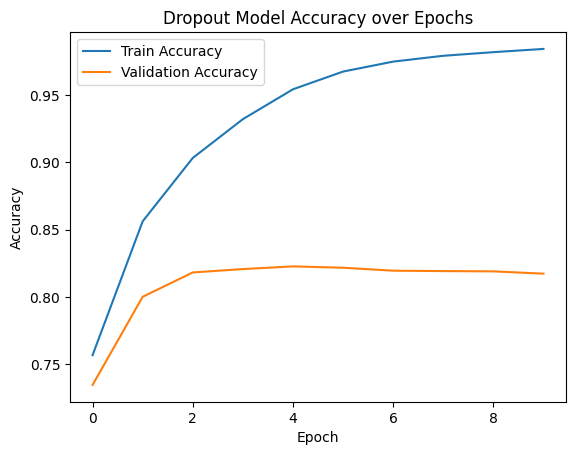

In [44]:
plt.plot(train_acc_list, label='Train Accuracy')
plt.plot(val_acc_list, label='Validation Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Dropout Model Accuracy over Epochs")
plt.legend()
plt.show()


In [46]:
# Recreate both model architectures
nodrop_model = NoDropoutNet(input_dim, hidden_dim, output_dim)
drop_model = DropoutNet(input_dim, hidden_dim, output_dim)

# Load saved weights
nodrop_model.load_state_dict(torch.load("nodropout_model.pth"))
drop_model.load_state_dict(torch.load("dropout_model.pth"))

nodrop_model.eval()
drop_model.eval()

# Evaluate both on the validation set
with torch.no_grad():
    nodrop_preds = torch.argmax(nodrop_model(X_val_tensor), dim=1)
    drop_preds = torch.argmax(drop_model(X_val_tensor), dim=1)

    acc_nodrop = accuracy_score(y_val_tensor, nodrop_preds)
    acc_drop = accuracy_score(y_val_tensor, drop_preds)

print(f"No Dropout Model - Validation Accuracy: {acc_nodrop:.4f}")
print(f"Dropout Model    - Validation Accuracy: {acc_drop:.4f}")


No Dropout Model - Validation Accuracy: 0.8119
Dropout Model    - Validation Accuracy: 0.8173
